In [1]:
import time
import sys
import os
import numpy as np
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from measurement.magneticresonance import pODMR, Rabi

from measurement.task_base import JobManager
import atexit
jm = JobManager()
def release_lock():
    return jm.stop()
atexit.register(release_lock)

<function __main__.release_lock()>

In [2]:
# load the hardware manager
# # add some devices to the server (if they aren't already added) ##################################################
import hardware.config_custom as hcf
from hardware.hardwaremanager import HardwareManager
from pathlib import Path
inserv = HardwareManager()
HERE = Path(path_project)
# pulse generator
try:
    inserv.add(
        'pg', 
        HERE / 'hardware' / 'pulser' / 'pulser.py', 
        'PulseGenerator', 
        [],
        dict(ip=hcf.PS_IP, chmap=hcf.PS_chmap, choffs=hcf.PS_choffs), 
    )
except Exception as ee:
    print(ee)

# mw signal generator
try:
    inserv.add(
        'mwsyn', 
        HERE / 'hardware' / 'mw' / 'mwsynthesizer.py', 
        'Synthesizer', 
        [hcf.VDISYN_SN], 
        dict(vidpid=hcf.VDISYN_VIDPID,
            baudrate=hcf.VDISYN_BAUD, 
            timeout=5, 
            write_timeout=5)
    )
except Exception as ee:
    print(ee)

# laser
try:
    inserv.add(
            'laser', 
            HERE / 'hardware' / 'laser' / 'laser.py', 
            'LaserControl', 
            [hcf.LASER_SN]
        )
except Exception as ee:
    print(ee)

Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
VDI Sythesizer Serail Port Open


In [3]:
podmr = pODMR()
stoptime = 2 # seconds
podmr.set_stoptime(stoptime) 
podmr.set_priority(10)
f_NVguess = 398.545
podmr.set_paraset(
    freq_start = (f_NVguess-0.04),
    freq_stop = (f_NVguess+0.04),
    freq_step = 0.2E-3,
    # init_laser = 1500.0,
    init_wait = 401.0,
    init_nslaser = 4.0,
    init_isc = 200,
    init_repeat = 20,
    mw_time = 2000.0,
    read_wait = 500.0,
    read_laser = 1201.0,
    mw_powervolt = 5.0,
    laser_current = 81.26, #0 to 100%
    min_volt = -0.002, # [V]
    max_volt = 0.010,
)

In [ ]:
jm.start()
jm.submit(podmr)
# podmr.pause()
time.sleep(stoptime)

in task base measurement, state is wait
Time taken for seqTranslator: 0.0121 seconds
Time taken for processing: 0.0547 seconds
Time taken for setting digital channels: 0.0967 seconds


Failed to set command 'CM=0.0'
Response from Device :'CM=0.00'


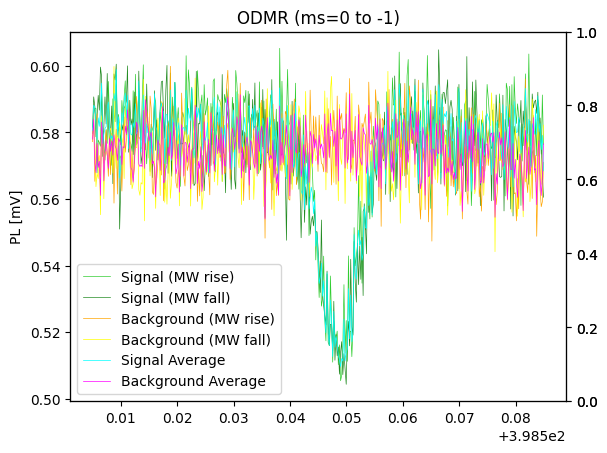

In [5]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax1.twinx()
freq = podmr.dataset["freq"]
sig_rise = podmr.dataset["sig_mw_rise"]
sig_fall = podmr.dataset["sig_mw_fall"]
sig_av = (sig_rise+sig_fall)/2

bg_rise = podmr.dataset["sig_nomw_rise"]
bg_fall = podmr.dataset["sig_nomw_fall"]
bg_av = (bg_rise+bg_fall)/2

ax1.plot(freq, sig_rise*1E3, linewidth=0.5, label="Signal (MW rise)", color="limegreen")
ax1.plot(freq, sig_fall*1E3, linewidth=0.5, label="Signal (MW fall)", color="forestgreen")
ax1.plot(freq, bg_rise*1E3, linewidth=0.5, label="Background (MW rise)", color="orange")
ax1.plot(freq, bg_fall*1E3, linewidth=0.5, label="Background (MW fall)", color="yellow")
ax1.plot(freq, sig_av*1E3, linewidth=0.5, label="Signal Average", color="cyan")
ax1.plot(freq, bg_av*1E3, linewidth=0.5, label="Background Average", color="magenta")


# ax1.set_xlabel("Frequency [GHz]")
ax1.set_ylabel("PL [mV]")
# ax2.set_ylabel("Contrast [%]", color='royalblue')
ax1.legend(loc='lower left')
plt.title("ODMR (ms=0 to -1)")
plt.show()

In [6]:
rabi = Rabi()
stoptime = 5 # seconds
rabi.set_stoptime(stoptime) 
rabi.set_priority(9) 
rabi.set_paraset(
            laser_current = 80.05, # percentage 
            mw_freq = 398.548, # GHz 
            mw_powervolt = 5.0, # voltage 0.0 to 5.0 
            mw_phasevolt = 0.0, # voltage 0.0 to 5.0
            init_nslaser = 40, # [ns]
            init_isc = 150,
            init_repeat = 40,
            init_wait = 401.0,
            read_wait = 300.0,
            read_laser = 1201.0,
            mw_dur_begin = 10.0,
            mw_dur_end = 3500,
            mw_dur_step = 50.0,  
            max_volt = 0.010,
            min_volt = -0.005
)


In [7]:
jm.start()
jm.submit(rabi)
time.sleep(stoptime)

in task base measurement, state is wait
Time taken for seqTranslator: 0.0020 seconds
Time taken for processing: 0.1143 seconds
Time taken for setting digital channels: 0.0338 seconds
Start the trigger from the pulse streamer


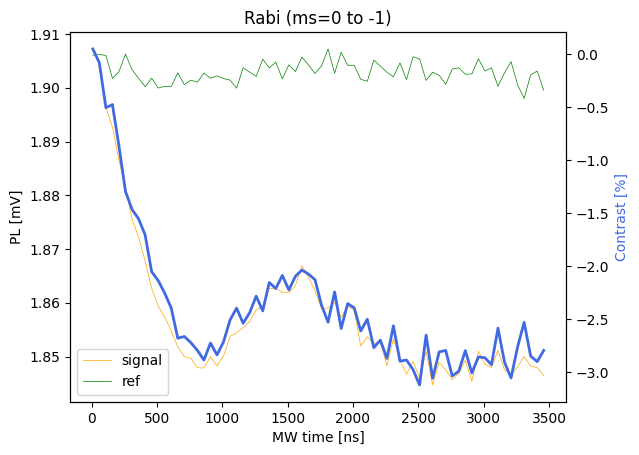

In [8]:
import matplotlib.pyplot as plt
mw_dur = rabi.dataset["mw_dur"]

signal_av = rabi.dataset["sig_mw"]
background_av = rabi.dataset["sig_nomw"]
contrast = (signal_av-background_av)/background_av
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
# mw_dur = np.arange(len(signal_av))
# ax1.plot(mw_dur, signal_av*1E3, linewidth=0.5, label="signal", color="orange")
# ax1.plot(mw_dur, background_av*1E3, linewidth=0.5, label="ref", color="green")
# ax2.plot(mw_dur, contrast*100.0, linewidth=2, label="contrast", color='royalblue')

# idxend = 200
ax1.plot(mw_dur, signal_av*1E3, linewidth=0.5, label="signal", color="orange")
ax1.plot(mw_dur, background_av*1E3, linewidth=0.5, label="ref", color="green")
ax2.plot(mw_dur, contrast*100.0, linewidth=2, label="contrast", color='royalblue')

ax1.set_xlabel("MW time [ns]")
ax1.set_ylabel("PL [mV]")
ax2.set_ylabel("Contrast [%]", color='royalblue')
ax1.legend(loc='best')
plt.title("Rabi (ms=0 to -1)")
plt.show()